In [1]:
import sys
sys.path.append('../')
import os
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from datetime import timedelta
import pickle
import datetime

from utils import utils_scenario as utils, data_preparation as prep, data_process as proc


In [2]:
def get_season(month):
    if month in [12,1,2]:
        return 1
    if month in [3,4,5]:
        return 2
    if month in [6,7,8]:
        return 3
    if month in [9,10,11]:
        return 4

def get_am(hour):
    if hour in range(0,12):
        return 1
    else:
        return 0
    
    
def get_one_forecast(DAY,HOUR):
    forecast_dir_path = main_dir + DAY + '_' + HOUR + '/'
    # Init output
    data = pd.DataFrame()
    # Init f_period
    period_root = 0
    # Read 2 meteo file
    for dir_day in os.listdir(forecast_dir_path):
        if len(dir_day) == 10:
            # load file
            data_per_day = pd.read_csv(forecast_dir_path + dir_day + '/meteo.txt',delimiter=";")
            data_per_day['date'] = dir_day.replace('_','-')
            data_per_day['f_period'] = period_root + data_per_day['heure']
            # append to output
            data = data.append(data_per_day)
            # add 1 day to fperiod
            period_root += 24

    # forecast date
    data['f_date'] = data['date'] + ' ' 
    data['f_date'] += data['heure'].map(lambda x : str(x).zfill(2))
    data['f_date'] += ':00:00'
    # present date
    data['p_date'] = DAY.replace('_','-') + ' ' + HOUR + ':00:00'

    # rename columns 
    data = data.rename(columns={'vitesse' : 'speed', 
                                'temperature' : 'temp', 
                                'rayonnement' : 'rad',
                                'direction' : 'wind_dir'})

    # compute cos and sin
    data['cos_wind_dir'] = np.cos(2 * np.pi * data['wind_dir'] / 360)
    data['sin_wind_dir'] = np.sin(2 * np.pi * data['wind_dir'] / 360)

    # select columns
    data = data[['p_date','f_date','speed','temp','rad','precip','cos_wind_dir','sin_wind_dir','wind_dir']]
    return data

### 1. Process Raw

In [3]:
#read daily measurement files
main_dir =  './data/raw/daily_measurement/'
measurement = pd.DataFrame()

#get the list of files:
for file_path in os.listdir(main_dir):
    measurement = measurement.append(pd.read_csv(main_dir + file_path))
    
measurement = measurement.reset_index(drop=True)

# Date format
measurement['datetime'] = pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')

# Drop na
measurement = measurement.set_index('datetime') \
              [['speed','temp', 'radiation', 'precip','wind_dir']] \
              .dropna(axis=0, how='all')
# Smooth wind direction 
measurement = prep.smooth_wind_dir(measurement)

# Init output measurement data
measurement_out = pd.DataFrame()
# Speed weighted hourly mean for sin & cos
measurement_out['cos_wind_dir'] = (measurement['cos_wind_dir'] * measurement['speed']).resample('H', label='right').sum() \
                                                   / measurement['speed'].resample('H', label='right').sum()
# Speed weighted hourly mean for sin & cos
measurement_out['sin_wind_dir'] = (measurement['sin_wind_dir'] * measurement['speed']).resample('H', label='right').sum() \
                                                   / measurement['speed'].resample('H', label='right').sum()

# Hourly mean for speed, temperature, radiation and precipitation
for col in ['speed','temp','radiation','precip']:
    measurement_out[col] = measurement[col].resample('1H', label='right').mean()
 
 #add caterogical features
measurement_out['season'] = measurement_out.index.month.map(get_season) # ordinal not categorical for linear models
measurement_out['am'] = measurement_out.index.hour.map(get_am)

measurement_out = measurement_out.reset_index()
# Add 1 hour to data because of hourly mean : data between 1am and 2am will be available at 2am
#measurement_out['datetime'] = measurement_out['datetime'] + datetime.timedelta(hours=1)

# Select columns
measurement_out = measurement_out[['datetime','speed','cos_wind_dir','sin_wind_dir','temp','radiation','precip','season']] #'am' feature is not currently in the model

smooth wind direction


In [4]:
#check if any col is missing
measurement_cols = pickle.load(open('measurement_cols.pkl', 'rb'))
print('checking missing columns are: ', (measurement_cols).difference(measurement_out.columns))

checking missing columns are:  Index([], dtype='object')


In [6]:
#save to processed 
measurement_out.to_csv('./data/processed_mit/last_measurement.csv',index=False)

In [7]:
#check for safi processed
measurement_safi = pd.read_csv('./data/processed_safi/last_measurement.csv')

measurement_mit = pd.read_csv('./data/processed_mit/last_measurement.csv')

In [11]:
#find intersect based on datetime
intersect = set(measurement_mit['datetime']).intersection(set(measurement_safi['datetime']))
df_mit= measurement_mit.loc[measurement_mit['datetime'].isin(intersect)]
df_safi= measurement_safi.loc[measurement_safi['datetime'].isin(intersect)]

#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'cos_wind_dir', 'sin_wind_dir', 'temp',
       'radiation', 'precip',]:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2)
    
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).round(0).drop_duplicates(keep=False)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on ='datetime', suffixes=('_safi', '_mit'))

,datetime,speed_safi,cos_wind_dir_safi,sin_wind_dir_safi,temp_safi,radiation_safi,precip_safi,season_safi,speed_mit,cos_wind_dir_mit,sin_wind_dir_mit,temp_mit,radiation_mit,precip_mit,season_mit
0,2020-07-16 06:00:00,0.0,1.0,1.0,25.0,0.0,0.0,3.0,0.0,NaN,NaN,25.0,0.0,0.0,3.0
1,2020-07-16 07:00:00,0.0,1.0,1.0,24.0,1.0,0.0,3.0,0.0,NaN,NaN,24.0,1.0,0.0,3.0
2,2020-07-17 07:00:00,0.0,-0.0,-1.0,22.0,0.0,0.0,3.0,0.0,NaN,NaN,22.0,0.0,0.0,3.0
3,2020-09-12 13:00:00,5.0,0.0,-1.0,26.0,665.0,0.0,4.0,5.0,0.0,-1.0,25.0,665.0,0.0,4.0
4,2020-09-19 02:00:00,2.0,0.0,1.0,20.0,0.0,0.0,4.0,2.0,0.0,1.0,21.0,0.0,0.0,4.0
5,2020-09-29 05:00:00,0.0,1.0,1.0,22.0,0.0,0.0,4.0,0.0,NaN,NaN,22.0,0.0,0.0,4.0
6,2020-09-29 06:00:00,0.0,1.0,1.0,22.0,0.0,0.0,4.0,0.0,NaN,NaN,22.0,0.0,0.0,4.0
7,2020-09-29 07:00:00,0.0,1.0,1.0,22.0,0.0,0.0,4.0,0.0,NaN,NaN,22.0,0.0,0.0,4.0
8,2020-09-29 08:00:00,0.0,1.0,1.0,22.0,6.0,0.0,4.0,0.0,NaN,NaN,22.0,6.0,0.0,4.0
9,2020-09-30 02:00:00,0.0,0.0,1.0,23.0,0.0,0.0,4.0,0.0,NaN,NaN,23.0,0.0,0.0,4.0


### 2. Get Forecast

In [13]:
main_dir = './data/raw/forecast/'
sub_dir = os.listdir(main_dir)

# concat files
forecast = pd.DataFrame()
for file_path in sub_dir:
    DAY = file_path[0:10]
    HOUR = file_path[11:13]
    forecast = forecast.append(get_one_forecast(DAY,HOUR))
forecast = forecast.reset_index(drop=True)
display(forecast.head())

,p_date,f_date,speed,temp,rad,precip,cos_wind_dir,sin_wind_dir,wind_dir
0,2020-07-06 00:00:00,2020-07-06 00:00:00,3.6,24.7,0,0.0,0.139173,0.990268,82
1,2020-07-06 00:00:00,2020-07-06 01:00:00,3.4,23.9,0,0.0,0.573576,0.819152,55
2,2020-07-06 00:00:00,2020-07-06 02:00:00,2.9,23.6,0,0.0,0.406737,0.913545,66
3,2020-07-06 00:00:00,2020-07-06 03:00:00,2.7,23.5,0,0.0,0.358368,0.933580,69
4,2020-07-06 00:00:00,2020-07-06 04:00:00,2.7,23.5,0,0.0,0.422618,0.906308,65


In [14]:
#change to dt 
forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')
forecast['p_date']= pd.to_datetime(forecast['p_date'],format='%Y-%m-%d %H:%M:%S')

#calculate forecast period (f_period)
forecast['f_period'] =forecast['f_date'] - forecast['p_date']
forecast['f_period'] = forecast['f_period'].dt.components['hours']+forecast['f_period'].dt.components['days']*24

#crop out <=6 hours 
forecast = forecast.loc[forecast['f_period']>=6]
forecast= prep.keep_last_forecast(forecast)
forecast.reset_index(inplace=True)

In [28]:
forecast[forecast['f_date'] == '2020-07-16 06:00:00']

,f_date,speed,temp,rad,precip,cos_wind_dir,sin_wind_dir,wind_dir,f_period
360,2020-07-16 06:00:00,2.7,22.0,0,0.0,0.573576,0.819152,55,6


In [16]:
#read pickle format columns 
forecast_cols = pickle.load(open('forecast_cols.pkl', 'rb'))
print('checking missing columns are: ', (forecast_cols).difference(forecast.columns))

checking missing columns are:  Index([], dtype='object')


In [17]:
forecast.to_csv('./data/processed_mit/last_forecast.csv',index=False)

In [46]:
#check for safi processed
df_safi = pd.read_csv('./data/processed_safi/last_forecast.csv')
df_mit = pd.read_csv('./data/processed_mit/last_forecast.csv')

#find intersect based on datetime
intersect = set(df_safi['f_date']).intersection(set(df_mit['f_date']))
df_mit= df_mit.loc[df_mit['f_date'].isin(intersect)]
df_safi= df_safi.loc[df_safi['f_date'].isin(intersect)]


#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'rad','cos_wind_dir', 'sin_wind_dir', 'temp', 'precip']:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2) 

df_mit = df_mit[['f_date','speed', 'rad','cos_wind_dir', 'sin_wind_dir', 'temp', 'precip']]
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).round().drop_duplicates(keep=False)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on ='f_date', suffixes=('_safi', '_mit'))

,f_date,speed_safi,temp_safi,rad_safi,precip_safi,cos_wind_dir_safi,sin_wind_dir_safi,speed_mit,temp_mit,rad_mit,precip_mit,cos_wind_dir_mit,sin_wind_dir_mit
0,2020-07-01 12:00:00,5.0,30.0,1023,0.0,1.0,0.0,4.0,32.0,911,0.0,1.0,0.0
1,2020-07-01 13:00:00,5.0,31.0,1030,0.0,1.0,0.0,4.0,34.0,947,0.0,1.0,0.0
2,2020-07-01 14:00:00,5.0,32.0,979,0.0,1.0,0.0,5.0,33.0,930,0.0,1.0,-0.0
3,2020-07-01 15:00:00,6.0,31.0,851,0.0,1.0,0.0,6.0,31.0,862,0.0,1.0,-0.0
4,2020-07-01 16:00:00,6.0,30.0,692,0.0,1.0,0.0,6.0,29.0,747,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,2020-10-13 15:00:00,6.0,30.0,603,0.0,1.0,0.0,6.0,31.0,603,0.0,1.0,0.0
542,2020-10-14 06:00:00,1.0,15.0,0,0.0,0.0,1.0,2.0,15.0,0,0.0,0.0,1.0
543,2020-10-14 12:00:00,3.0,25.0,702,0.0,1.0,0.0,4.0,26.0,702,0.0,1.0,0.0
544,2020-10-14 13:00:00,4.0,26.0,724,0.0,1.0,0.0,4.0,27.0,724,0.0,1.0,0.0


### 3. Make Prediction

In [47]:
#read in processed measurement data and forecast data
measurement = pd.read_csv('./data/processed_mit/last_measurement.csv')
measurement['datetime']= pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')
forecast = pd.read_csv('./data/processed_mit/last_forecast.csv')
forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')


In [48]:
#prepare processed data into same format as training df 
def prepare_x_test(measurement, forecast, past_n_steps, pred_period):
    
    #concat past n steps from measurement 
    df = measurement.set_index('datetime')
    #drop am feature
#     df = df.drop(['am'], axis=1)
    df=proc.get_past_n_steps(df, past_n_steps)
    #calculate forecast_time
    df['forecast_time'] = df['present_time']+timedelta(hours=pred_period)

    #join forecast according to forecast time 
    forecast = forecast.set_index('f_date') 
    forecast = forecast.add_suffix('_forecast')
    df = pd.merge(df, forecast, how = 'left', left_on = 'forecast_time', right_on ='f_date')
    #add cos day
    df = proc.smooth_day_hour(df)
    #fillna
    df.fillna(value=0, inplace=True)
    df = df.iloc[:-past_n_steps]
    #keep the present_time information 
#     df_out = df.loc[df['present_time']]
    return df 

In [49]:
#check if any col is missing 
df= prepare_x_test(measurement, forecast, 48, 6)
#load model columns 
model_cols = pickle.load(open('model_cols_past_48.pkl', 'rb'))
print('columns missing:', model_cols.difference(df.columns))

columns missing: Index([], dtype='object')


In [50]:
df

,speed_t-48,cos_wind_dir_t-48,sin_wind_dir_t-48,temp_t-48,radiation_t-48,precip_t-48,season_t-48,speed_t-47,cos_wind_dir_t-47,sin_wind_dir_t-47,...,speed_forecast,temp_forecast,rad_forecast,precip_forecast,cos_wind_dir_forecast,sin_wind_dir_forecast,wind_dir_forecast,f_period_forecast,cos_day,cos_hour
0,3.456667,0.792975,0.531931,24.728333,0.000000,0.0,3,2.985000,0.762135,0.546467,...,2.3,22.6,118.0,0.0,0.544639,0.838671,57.0,7.0,0.962309,0.965926
1,2.985000,0.762135,0.546467,24.766667,0.000000,0.0,3,2.621667,0.686465,0.687781,...,1.8,24.5,321.0,0.0,0.656059,0.754710,49.0,8.0,0.962309,0.866025
2,2.621667,0.686465,0.687781,24.663333,0.000000,0.0,3,3.813333,0.534738,0.809940,...,1.1,26.8,513.0,0.0,0.874620,0.484810,29.0,9.0,0.962309,0.707107
3,3.813333,0.534738,0.809940,25.000000,0.000000,0.0,3,4.871667,0.554270,0.797444,...,1.5,29.1,682.0,0.0,0.190809,-0.981627,281.0,10.0,0.962309,0.500000
4,4.871667,0.554270,0.797444,24.836667,0.000000,0.0,3,3.851667,0.460468,0.849839,...,3.0,29.3,815.0,0.0,0.034899,-0.999391,272.0,11.0,0.962309,0.258819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,5.446667,0.920738,0.107265,26.086667,67.750000,0.0,4,3.693333,0.863875,0.312169,...,2.6,16.0,0.0,0.0,0.573576,0.819152,55.0,37.0,0.966848,0.258819
2203,3.693333,0.863875,0.312169,24.110000,1.816667,0.0,4,2.975000,0.638117,0.728681,...,2.0,15.5,0.0,0.0,0.515038,0.857167,59.0,38.0,0.966848,0.500000
2204,2.975000,0.638117,0.728681,22.868333,0.000000,0.0,4,2.553333,0.566606,0.785955,...,1.4,14.8,0.0,0.0,0.438371,0.898794,64.0,39.0,0.966848,0.707107
2205,2.553333,0.566606,0.785955,22.151667,0.000000,0.0,4,2.546667,0.485717,0.849224,...,1.0,14.3,0.0,0.0,0.406737,0.913545,66.0,40.0,0.966848,0.866025


In [51]:
predict_list = np.arange(1,49,1) 
#predict result for all hours 
predict_all = pd.DataFrame() 
for pred in predict_list:
    #predict result for one hour
    predict = pd.DataFrame(columns={'present_time','forecast_time','speed','cos_wind_dir','sin_wind_dir'})
    x_test = prepare_x_test(measurement, forecast, 48, int(pred))
    #drop timestamp columns and change to array format
    predict['forecast_time'] = x_test['forecast_time']
    predict['present_time']= x_test['present_time'] 
    
    x_test = x_test.drop(['present_time','forecast_time'], axis=1)

    #check missing features 
    xgb1 = pickle.load(open('../trained_models/speed_t_'+str(pred), 'rb'))
    model_features = xgb1.get_booster().feature_names
    missing_features = set(model_features).difference(x_test.columns)
    if len(missing_features)>=1:
        print('model not run because some features are missing:', missing_features)
        break 
    else:
        #re-order features 
        x_test = x_test[model_features]

    #read 3 models for speed, cos_wind, sin_wind
    xgb1= pickle.load(open('../trained_models/speed_t_'+str(pred), 'rb'))
    xgb2 = pickle.load(open('../trained_models/cos_wind_dir_t_'+str(pred), 'rb'))
    xgb3 = pickle.load(open('../trained_models/sin_wind_dir_t_'+str(pred), 'rb'))

    #predict 
    predict['speed'] = xgb1.predict(x_test)
    predict['cos_wind_dir'] = xgb2.predict(x_test)
    predict['sin_wind_dir'] = xgb3.predict(x_test)
    
    #calculate wind_dir
    predict['wind_dir'] = predict.apply(lambda row: utils.get_angle_in_degree(row['cos_wind_dir'],row['sin_wind_dir']),axis = 1)
    
    predict_all=predict_all.append(predict)

cos and sin out of range, returned 0


In [52]:
#sort values:
predict_all.sort_values(['present_time','forecast_time'])

,speed,cos_wind_dir,sin_wind_dir,forecast_time,present_time,wind_dir
0,1.602836,0.614693,0.309874,2020-07-16 02:00:00,2020-07-16 01:00:00,52.070367
0,1.657390,0.637936,0.485308,2020-07-16 03:00:00,2020-07-16 01:00:00,50.361885
0,1.990215,0.574288,0.508354,2020-07-16 04:00:00,2020-07-16 01:00:00,54.950226
0,2.254656,0.547456,0.721344,2020-07-16 05:00:00,2020-07-16 01:00:00,56.807368
0,2.907371,0.507639,0.776429,2020-07-16 06:00:00,2020-07-16 01:00:00,59.493277
...,...,...,...,...,...,...
2206,4.494784,0.407531,-0.188911,2020-10-17 19:00:00,2020-10-15 23:00:00,294.049802
2206,3.591880,0.383402,-0.031854,2020-10-17 20:00:00,2020-10-15 23:00:00,292.544562
2206,3.515682,0.476195,0.129348,2020-10-17 21:00:00,2020-10-15 23:00:00,61.562803
2206,3.423721,0.370055,0.553776,2020-10-17 22:00:00,2020-10-15 23:00:00,68.280989


In [53]:
predict_all.to_csv('./data/results_log/results_mit.csv',index=False)

In [54]:
# #load all prediction results from safi 
# main_dir =  './data/results_log/'
# predict_safi = pd.DataFrame()
# #get the list of files:
# for file_path in os.listdir(main_dir):
#     predict_safi = predict_safi.append(pd.read_csv(main_dir + file_path))  
# predict_safi = predict_safi.reset_index(drop=True)

predict_safi = pd.read_csv('./data/results_log/result_2020-10-15 22.csv')

In [57]:
predict_mit = pd.read_csv('./data/results_log/results_mit.csv')

In [59]:
# #check for differences 
df_safi = predict_safi.copy()
df_mit = predict_mit.copy()

# #find intersect based on datetime
intersect = set(df_safi['forecast_time']).intersection(set(df_mit['forecast_time']))
df_mit= df_mit.loc[df_mit['forecast_time'].isin(intersect)]
df_safi= df_safi.loc[df_safi['forecast_time'].isin(intersect)]


#round columns to 2 decimal places for comparison 
for col in [ 'speed', 'cos_wind_dir', 'sin_wind_dir','wind_dir']:
    df_safi[col]= df_safi[col].round(2)
    df_mit[col] = df_mit[col].round(2)
    
#find the rows of different entries, by concatenating below and drop duplicates
differences = pd.concat([df_safi,df_mit], keys=['safi', 'mit']).drop_duplicates(keep=False).round(1)
#print the places where values are different 
pd.merge(differences.loc['safi'],differences.loc['mit'], on =['forecast_time','present_time'], suffixes=('_safi', '_mit'))

,cos_wind_dir_safi,forecast_time,present_time,sin_wind_dir_safi,speed_safi,wind_dir_safi,cos_wind_dir_mit,sin_wind_dir_mit,speed_mit,wind_dir_mit
0,0.4,2020-10-17 15:00:00,2020-10-15 22:00:00,-0.5,4.9,294.0,0.4,-0.5,4.9,294.1


### Check Performance

In [65]:
measurement = pd.read_csv('./data/processed_mit/last_measurement.csv')
measurement['datetime'] = pd.to_datetime(measurement['datetime'],format='%Y-%m-%d %H:%M:%S')
measurement = measurement.dropna()
#calculate wind_dir
measurement['wind_dir'] = measurement.apply(lambda row: utils.get_angle_in_degree(row['cos_wind_dir'],row['sin_wind_dir']),axis = 1)
    
# predict_mit = pd.read_csv('./data/results_mit/all_results.csv')
# Date format
predict_mit['present_time'] = pd.to_datetime(predict_mit['present_time'],format='%Y-%m-%d %H:%M:%S')
predict_mit['forecast_time'] = pd.to_datetime(predict_mit['forecast_time'],format='%Y-%m-%d %H:%M:%S')
#calculate prediction period 
predict_mit['f_period'] = (predict_mit['forecast_time'] - predict_mit['present_time'])/np.timedelta64(1, 'h')

In [66]:
# #load all prediction results from safi 
# main_dir =  './data/results_safi/'
# predict_safi = pd.DataFrame()
# #get the list of files:
# for file_path in os.listdir(main_dir):
#     predict_safi = predict_safi.append(pd.read_csv(main_dir + file_path))  
# predict_safi = predict_safi.reset_index(drop=True)
# Date format
predict_safi['present_time'] = pd.to_datetime(predict_safi['present_time'],format='%Y-%m-%d %H:%M:%S')
predict_safi['forecast_time'] = pd.to_datetime(predict_safi['forecast_time'],format='%Y-%m-%d %H:%M:%S')
#calculate prediction period 
predict_safi['f_period'] = (predict_safi['forecast_time'] - predict_safi['present_time'])/np.timedelta64(1, 'h')

In [67]:
#load official forecast - taking last forecasts  
# main_dir = './data/raw/forecast/'
# sub_dir = os.listdir(main_dir)

# # concat files
# forecast = pd.DataFrame()
# for file_path in sub_dir:
#     DAY = file_path[0:10]
#     HOUR = file_path[11:13]
#     forecast = forecast.append(get_one_forecast(DAY,HOUR))

# #change to dt 
# forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')
# forecast['p_date']= pd.to_datetime(forecast['p_date'],format='%Y-%m-%d %H:%M:%S')

# #calculate forecast period (f_period)
# forecast['f_period'] =forecast['f_date'] - forecast['p_date']
# forecast['f_period'] = forecast['f_period'].dt.components['hours']+forecast['f_period'].dt.components['days']*24

# #crop out <=6 hours 
# forecast = forecast.loc[forecast['f_period']>=6]

# forecast.reset_index(inplace=True)


In [68]:
forecast= pd.read_csv('./data/processed_mit/last_forecast.csv')
forecast['f_date']= pd.to_datetime(forecast['f_date'],format='%Y-%m-%d %H:%M:%S')


In [69]:
# define a function to calculate the error of angles: taking into account of cyclical nature 
# error for a pair of angles 
def angle_diff(a1, a2):
    if abs(a1-a2) <= 180:
        mae = abs(a1-a2)
    else:
        mae = 360 - abs(a1-a2)
    return mae 
# mae applied to series 
def angle_mae(df, col1, col2):
    error= df.apply(lambda row: angle_diff(row[col1],row[col2]),axis = 1)
    return error.mean()


In [117]:
from sklearn import metrics
predict_list = np.arange(1,48,1) 
#predict result for all hours 
accuracy = pd.DataFrame() 
predict_all = pd.DataFrame()
#get 1 hour prediction accuracy:
for pred  in predict_list: 
    print(pred)
    df_mit= predict_mit.loc[predict_mit['f_period']==pred]
    df_safi= predict_safi.loc[predict_safi['f_period']==pred]
    #find intersect based on datetime
    intersect = set(df_safi['forecast_time']).intersection(set(df_mit['forecast_time']))
    df_mit= df_mit.loc[df_mit['forecast_time'].isin(intersect)]
    df_safi= df_safi.loc[df_safi['forecast_time'].isin(intersect)]
    
    df_merge= pd.merge(df_mit, df_safi, how = 'inner', on = 'forecast_time', suffixes=('_mit','_safi'))
    

    
#     df_merge= pd.merge(measurement, predict_merge, how = 'inner', 
#                        left_on = 'datetime', right_on = 'forecast_time', 
#                        suffixes=('_real','_predict'))
#     print(df_merge)
    
    df_merge = pd.merge(df_merge, forecast, how = 'left', 
                        left_on = 'forecast_time', right_on = 'f_date', suffixes=(None,'_ofcl'))
    
    df_merge = df_merge.reset_index(drop=True)
    predict_all = predict_all.append(df_merge, ignore_index=True)

#     speed_mae_mit = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_mit'])
#     angle_mae_mit =angle_mae(df_merge,'wind_dir', 'wind_dir_mit')
#     speed_mae_safi = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_safi'])
#     angle_mae_safi = angle_mae(df_merge,'wind_dir', 'wind_dir_safi')
#     speed_mae_ofcl = metrics.mean_absolute_error(df_merge['speed'], df_merge['speed_ofcl'])
#     angle_mae_ofcl = angle_mae(df_merge,'wind_dir', 'wind_dir_ofcl')
    
#     #record accuracy
#     accuracy = accuracy.append({'pred_n_steps': str(pred),
#                                 'speed_mae_mit': speed_mae_mit,
#                                 'speed_mae_safi': speed_mae_safi,
#                                 'angle_mae_mit': angle_mae_mit,
#                                 'angle_mae_safi': angle_mae_safi,
#                                 'speed_mae_ofcl': speed_mae_ofcl,
#                                 'angle_mae_ofcl': angle_mae_ofcl
#                                }, ignore_index=True)  
# accuracy   

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [118]:
# predict_safi.loc[predict_safi['f_period']==2]
# predict_safi['forecast_time'].dtype
# df_mit[df_mit['forecast_time'] == df_safi['forecast_time']]
# df_safi['forecast_time']
# df_merge
predict_all

,speed_mit,cos_wind_dir_mit,sin_wind_dir_mit,forecast_time,present_time_mit,wind_dir_mit,f_period_mit,cos_wind_dir_safi,present_time_safi,sin_wind_dir_safi,...,f_period_safi,f_date,speed,temp,rad,precip,cos_wind_dir,sin_wind_dir,wind_dir,f_period
0,2.952733,0.585860,0.770459,2020-10-15 23:00:00,2020-10-15 22:00:00,54.136235,1.0,0.585860,2020-10-15 22:00:00,0.770459,...,1.0,2020-10-15 23:00:00,3.7,17.0,0.0,0.0,0.731354,0.681998,43.0,35.0
1,2.994185,0.527268,0.783131,2020-10-16 00:00:00,2020-10-15 22:00:00,58.178955,2.0,0.527268,2020-10-15 22:00:00,0.783131,...,2.0,2020-10-16 00:00:00,3.0,16.5,0.0,0.0,0.656059,0.754710,49.0,36.0
2,2.675729,0.461387,0.890832,2020-10-16 01:00:00,2020-10-15 22:00:00,62.523369,3.0,0.461387,2020-10-15 22:00:00,0.890832,...,3.0,2020-10-16 01:00:00,2.6,16.0,0.0,0.0,0.573576,0.819152,55.0,37.0
3,2.421884,0.300502,0.884444,2020-10-16 02:00:00,2020-10-15 22:00:00,72.512243,4.0,0.300502,2020-10-15 22:00:00,0.884444,...,4.0,2020-10-16 02:00:00,2.0,15.5,0.0,0.0,0.515038,0.857167,59.0,38.0
4,2.489255,0.193506,0.976389,2020-10-16 03:00:00,2020-10-15 22:00:00,78.842561,5.0,0.193506,2020-10-15 22:00:00,0.976389,...,5.0,2020-10-16 03:00:00,1.4,14.8,0.0,0.0,0.438371,0.898794,64.0,39.0
5,2.126696,0.145790,0.914548,2020-10-16 04:00:00,2020-10-15 22:00:00,81.616958,6.0,0.145790,2020-10-15 22:00:00,0.914548,...,6.0,2020-10-16 04:00:00,1.0,14.3,0.0,0.0,0.406737,0.913545,66.0,40.0
6,2.483975,0.142624,0.934541,2020-10-16 05:00:00,2020-10-15 22:00:00,81.800257,7.0,0.142624,2020-10-15 22:00:00,0.934541,...,7.0,2020-10-16 05:00:00,0.9,13.9,0.0,0.0,0.173648,0.984808,80.0,41.0
7,2.565509,0.090074,0.940490,2020-10-16 06:00:00,2020-10-15 22:00:00,84.832108,8.0,0.090074,2020-10-15 22:00:00,0.940490,...,8.0,2020-10-16 06:00:00,1.1,13.8,0.0,0.0,-0.258819,0.965926,105.0,42.0
8,2.087402,-0.025529,0.951967,2020-10-16 07:00:00,2020-10-15 22:00:00,91.462888,9.0,-0.025529,2020-10-15 22:00:00,0.945130,...,9.0,2020-10-16 07:00:00,1.2,13.9,0.0,0.0,-0.515038,0.857167,121.0,43.0
9,2.249485,-0.112953,0.977757,2020-10-16 08:00:00,2020-10-15 22:00:00,96.485575,10.0,-0.112953,2020-10-15 22:00:00,0.977757,...,10.0,2020-10-16 08:00:00,1.4,15.5,130.0,0.0,-0.559193,0.829038,124.0,44.0


Text(0, 0.5, 'MAE (km/h)')

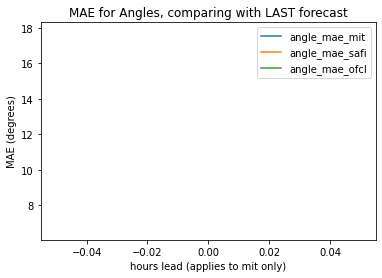

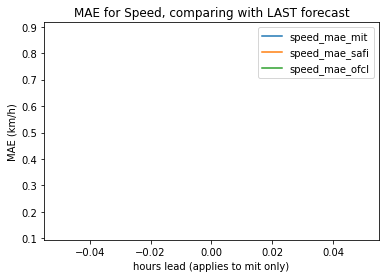

In [71]:
import matplotlib.pyplot as plt
#plots 
ax = accuracy[['angle_mae_mit','angle_mae_safi','angle_mae_ofcl']].plot(title='MAE for Angles, comparing with LAST forecast')
ax.set_xlabel("hours lead (applies to mit only)")
ax.set_ylabel("MAE (degrees)")

ax = accuracy[['speed_mae_mit','speed_mae_safi','speed_mae_ofcl']].plot(title='MAE for Speed, comparing with LAST forecast')
ax.set_xlabel("hours lead (applies to mit only)")
ax.set_ylabel("MAE (km/h)")

In [83]:
#save to csv 
accuracy.to_csv('accuracy_comparison.csv', index=False)